In [63]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from scipy import ndimage

In [64]:


def load_image(filename, as_gray=False, as_float=False):
    if as_gray:
        a = np.asarray(Image.open(filename).convert('L'))
    else:
        a = np.asarray(Image.open(filename))
    if as_float:
        return a.astype(np.float) / 255
    else:
        return a

def display_image(im, as_gray=False, title=None):
    plt.figure(figsize=(9,4))
    if as_gray:
        plt.imshow(im, cmap='gray')
    else:
        plt.imshow(im)
    if title is not None:
        plt.title(title)

def display_vec(v, title=None):
    plt.figure(figsize=(9,4))
    plt.plot(v)
    if title is not None:
        plt.title(title)
        

im = load_image('CircleLineRect.png', as_gray=False, as_float=False)

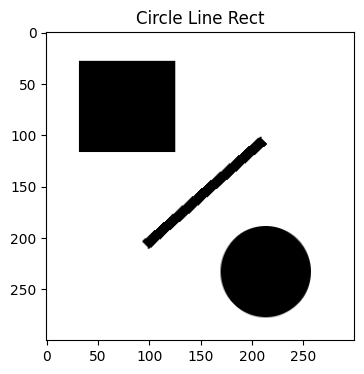

In [65]:
display_image(im=im, as_gray=True, title='Circle Line Rect')

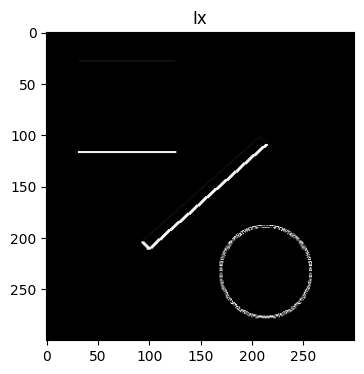

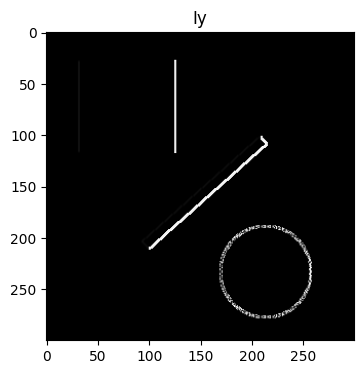

In [76]:
#Both partial derivatives


#Give me the partial derivatives of the image Ix, Iy and Ixy

# TODO
Ix = ndimage.sobel(im, axis=0)
Iy = ndimage.sobel(im, axis=1)


display_image(Ix, as_gray=True, title='Ix')
display_image(Iy, as_gray=True, title='Iy')

#Call ndimage.sonel without gradient normalization

# TODO






![Alt text](image.png)

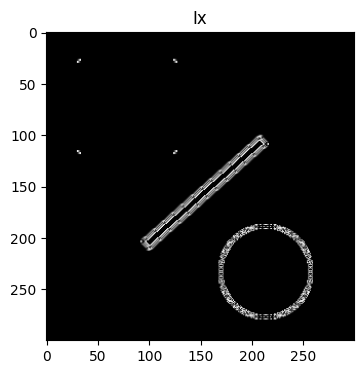

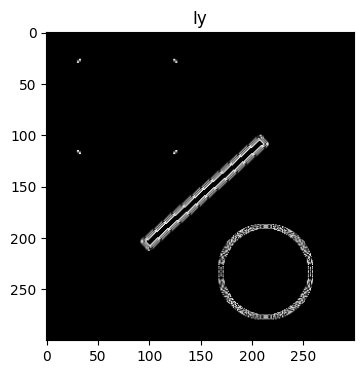

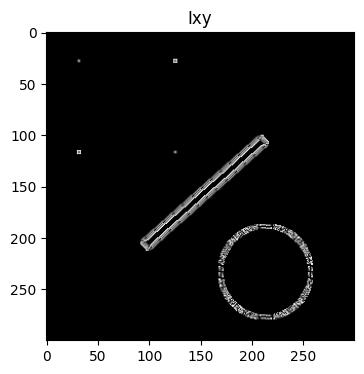

In [69]:

Ix2 = ndimage.sobel(Ix, axis=0)
Iy2 = ndimage.sobel(Iy, axis=1)
Ixy = ndimage.sobel(Ix, axis=1)

display_image(Ix2, as_gray=True, title='Ix')
display_image(Iy2, as_gray=True, title='Iy')
display_image(Ixy, as_gray=True, title='Ixy')


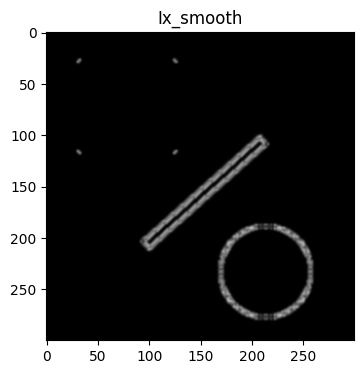

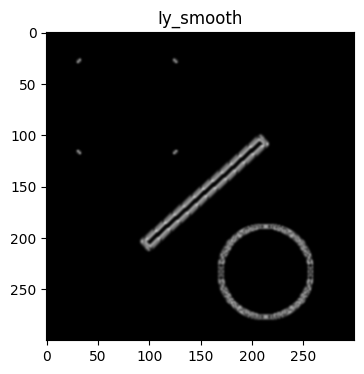

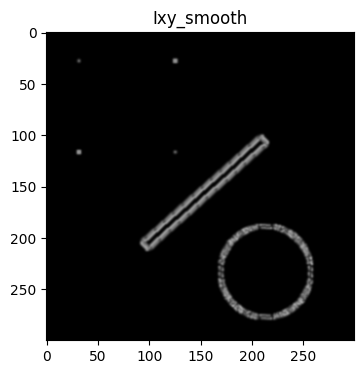

In [72]:
#Smooth version of the partial derivatives
sigma = 1
Ix2_smooth = ndimage.gaussian_filter(Ix2, sigma)
Iy2_smooth = ndimage.gaussian_filter(Iy2, sigma)
Ixy_smooth = ndimage.gaussian_filter(Ixy, sigma)

display_image(Ix2_smooth, as_gray=True, title='Ix_smooth')
display_image(Iy2_smooth, as_gray=True, title='Iy_smooth')
display_image(Ixy_smooth, as_gray=True, title='Ixy_smooth')
